# Multi-class change detection using image segmentation deep learning models

> * 🔬 Data Science
> * 🥠 Deep Learning and image segmentation

## Table of Contents

* [Introduction](#Introduction)
* [Necessary imports](#Necessary-imports)
* [Connect to your GIS](#Connect-to-your-GIS)
* [Export training data](#Export-training-data)
* [Model training](#Model-training)
  * [Prepare data](#Prepare-data)
  * [Load UNet model architecture](#Load-UNet-model-architecture)
  * [Tuning for optimal learning rate](#Tuning-for-optimal-learning-rate)
  * [Fit the model](#Fit-the-model)
  * [Visualize results](#Visualize-results)
  * [Save the model](#Save-the-model)
* [Model inferencing](#Model-inferencing)
  * [Generate change raster using classify pixels using deep learning tool](#Generate-change-raster-using-classify-pixels-using-deep-learning-tool)
  * [Visualize change map](#Visualize-change-map)
* [Conclusion](#Conclusion)
* [References](#References)

# Introduction

Change detection is used in global remote sensing to find out changes in landcover over a period of time by natural/man-made activities over a wide area in many applications including environmental monitoring, disaster evaluation, and urban expansion studies. Current change detection methods typically follow one of two approaches, utilising either post-classification analysis,or difference image analysis. These methods are often resource-heavy and time intensive. 

In this notebook, we will show a novel way to detect and classify change using semantic segmentation models available in `arcgis.learn`. For more details about model and its working refer [How U-net works?](https://developers.arcgis.com/python/guide/how-unet-works/) in guide section.

## Necessary imports

In [21]:
from arcgis import GIS
from arcgis.learn import prepare_data, PSPNetClassifier, UnetClassifier, DeepLab

## Connect to your GIS

In [27]:
gis = GIS('Home')
ent_gis = GIS('https://pythonapi.playground.esri.com/portal', 'arcgis_python', 'amazing_arcgis_123')

## Export training data

For this usecase, we have landsat-7 imageries and classified change map with class information between two time periods i.e. 2001, 2016, collected over Egypt with spatial resolution of 30 m. We will export the data in “Classified_tiles” metadata format available in the `Export Training Data For Deep Learning` tool. The tool is available in [ArcGIS Pro](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview) as well as [ArcGIS Image Server](https://www.esri.com/en-us/arcgis/products/arcgis-image-server).

For the model to identify changes between imageries, we will build a composite of the imageries of two time period using [composite](https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/composite-bands.htm) tool in ArcGIS Pro. It will be provided as `Input Raster` to the model, while change map will be provided as labels.

- `Input Raster`: Composite_imagery_2001_2016
- `Input feature class or classified raster`: change_map_2001_2016
- `Tile Size X & Tile Size Y`: 256
- `Stride X & Stride Y`: 128
- `Meta Data Format`: 'Classified_Tiles' as we are training a segmentation model.
- `Environments`: Set optimum `Cell Size`, `Processing Extent`.

Raster's used for exporting the training dataset are provided below

In [23]:
landsat_composite_2001_16 = ent_gis.content.get('dbe2221e4e1240e986586f0eb3a1479b')
landsat_composite_2001_16

<Item title:"train_area_landsat_composite_2001_16" type:Imagery Layer owner:api_data_owner>

In [24]:
landsat_changemap_2001_16 = ent_gis.content.get('8eef999714d64e9f9494030b9c5f76c2')
landsat_changemap_2001_16

<Item title:"train_area_changemap_tif" type:Imagery Layer owner:api_data_owner>

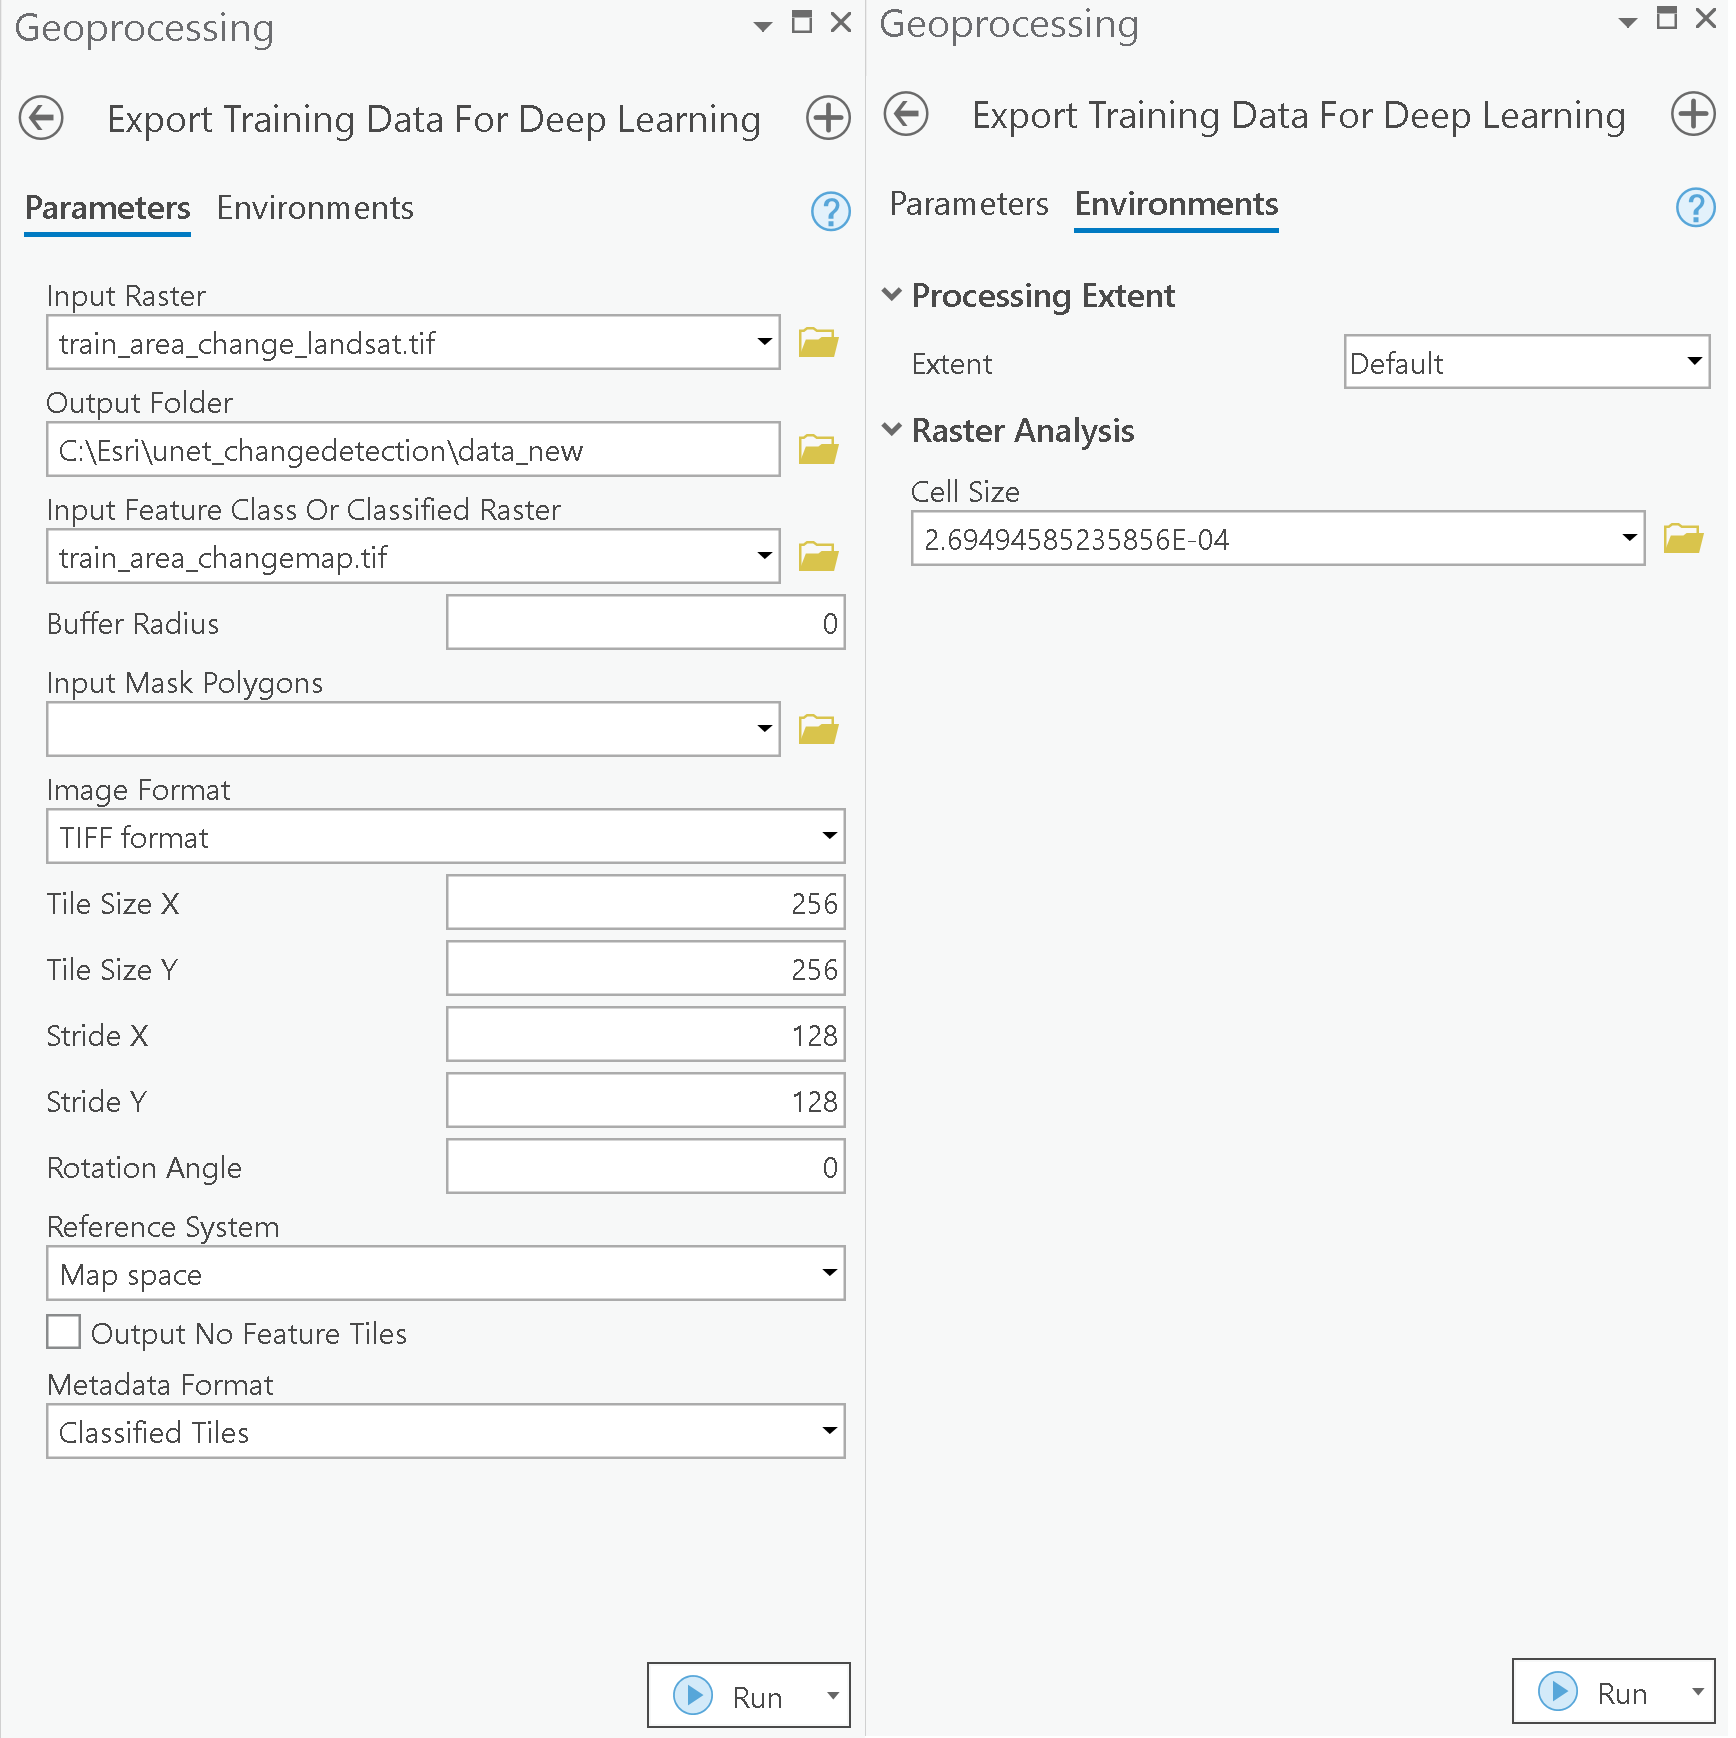

## Model training

Alternatively, we have provided a subset of training data containing a few samples and also provided the rasters used for exporting the training dataset. You can use the data directly to run the experiments.

<Item title:"multi_change_detection_dataset" type:Image Collection owner:api_data_owner>
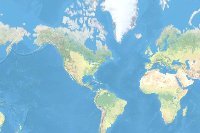

In [26]:
training_data = gis.content.get('3aedfa7e790541a79730eb1db47ed419')
training_data

In [ ]:
filepath = training_data.download(file_name=training_data.name)

In [ ]:
#Extract the data from the zipped image collection

with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

### Prepare data

In [ ]:
output_path = Path(os.path.join(os.path.splitext(filepath)[0]))

In [10]:
data=prepare_data(path=r'C:\Esri_project\unet_changedetection\modis_change\data_new', batch_size=1)

#### Visualize a few samples from your training data

To get a sense of what the training data looks like, `arcgis.learn.show_batch()` method randomly picks a few training chips and visualize them.

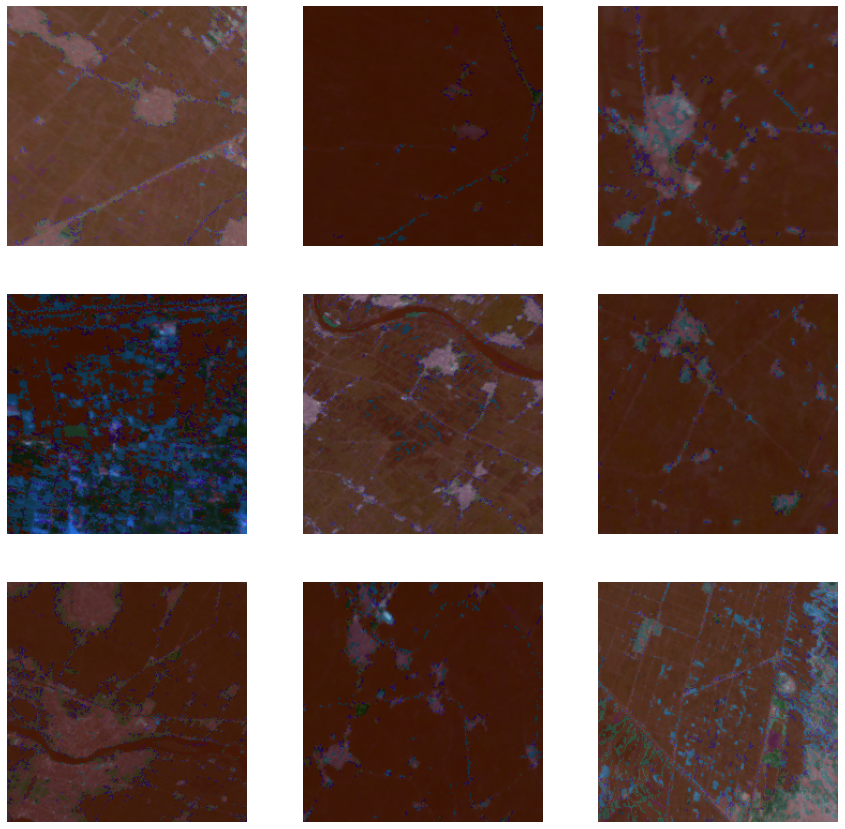

In [12]:
data.show_batch(alpha=0.5)

### Load U-Net model architecture

In [13]:
model = UnetClassifier(data,focal_loss=True, class_balancing=True, dice_loss_fraction=0.5, ignore_class=[11])

### Tuning for optimal learning rate

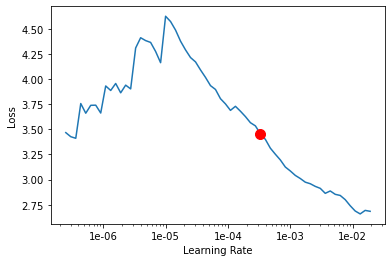

In [14]:
lr = model.lr_find()

### Fit the model

The model is trained for around a few epochs with the suggested learning rate.

In [41]:
model.fit(10, lr, one_cycle=True, checkpoint=False)

epoch,train_loss,valid_loss,accuracy,dice,time
0,0.138059,0.175188,0.849634,0.849634,02:10
1,0.167470,0.261953,0.809135,0.809135,02:10
2,0.182361,0.375001,0.766851,0.766851,02:10
3,0.167827,0.313119,0.826512,0.826512,02:05
4,0.175692,0.388535,0.789183,0.789183,02:06
5,0.159731,0.170087,0.845855,0.845855,02:07
6,0.141194,0.224625,0.834233,0.834233,02:08
7,0.134880,0.139973,0.848828,0.848828,02:07
8,0.133818,0.182892,0.819617,0.819617,02:08
9,0.134821,0.196819,0.836628,0.836628,02:09


Here, with 10 epochs, we can see reasonable results — both training and validation losses have gone down considerably, indicating that the model is learning detect changes in pixel.

### Visualize results

It is a good practice to see results of the model viz-a-viz ground truth. The code below picks random samples and shows us ground truth and model predictions, side by side. This enables us to preview the results of the model within the notebook.

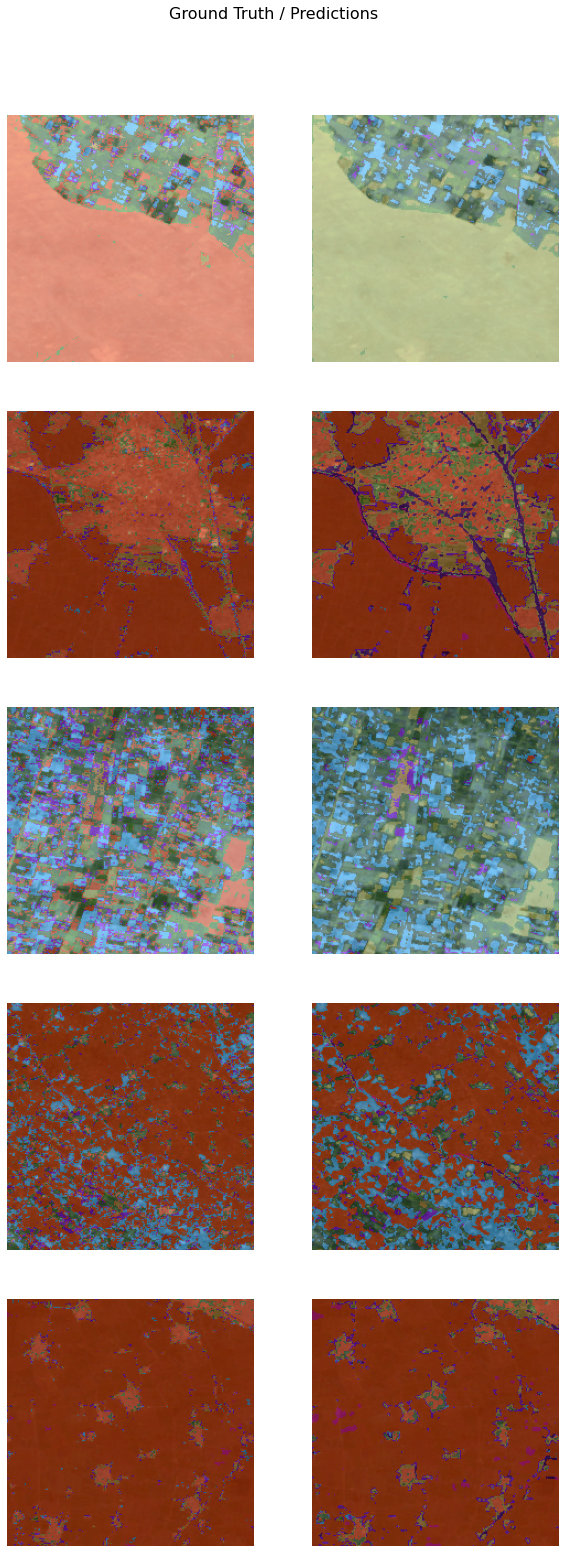

In [28]:
model.show_results()

### Save the model

We will save the model which we trained as a 'Deep Learning Package' ('.dlpk' format). Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform.

We will use the save() method to save the trained model. By default, it will be saved to the 'models' sub-folder within our training data folder.

In [ ]:
model.save(r'unet_change_model_modis_e10')

## Model inferencing

### Generate change raster using classify pixels using deep learning tool

After we trained the change detection model and saved the weights for detecting changes. we could use the `classify pixels using deep learning tool` avialable in both `ArcGIS pro` and `ArcGIS Enterprise` for inferencing at scale.

In [29]:
test_data = ent_gis.content.get('8e0ca6e7cefb45289eccc0e7ae2c9bfd')
test_data

<Item title:"test_area_change_landsat_tif" type:Imagery Layer owner:api_data_owner>

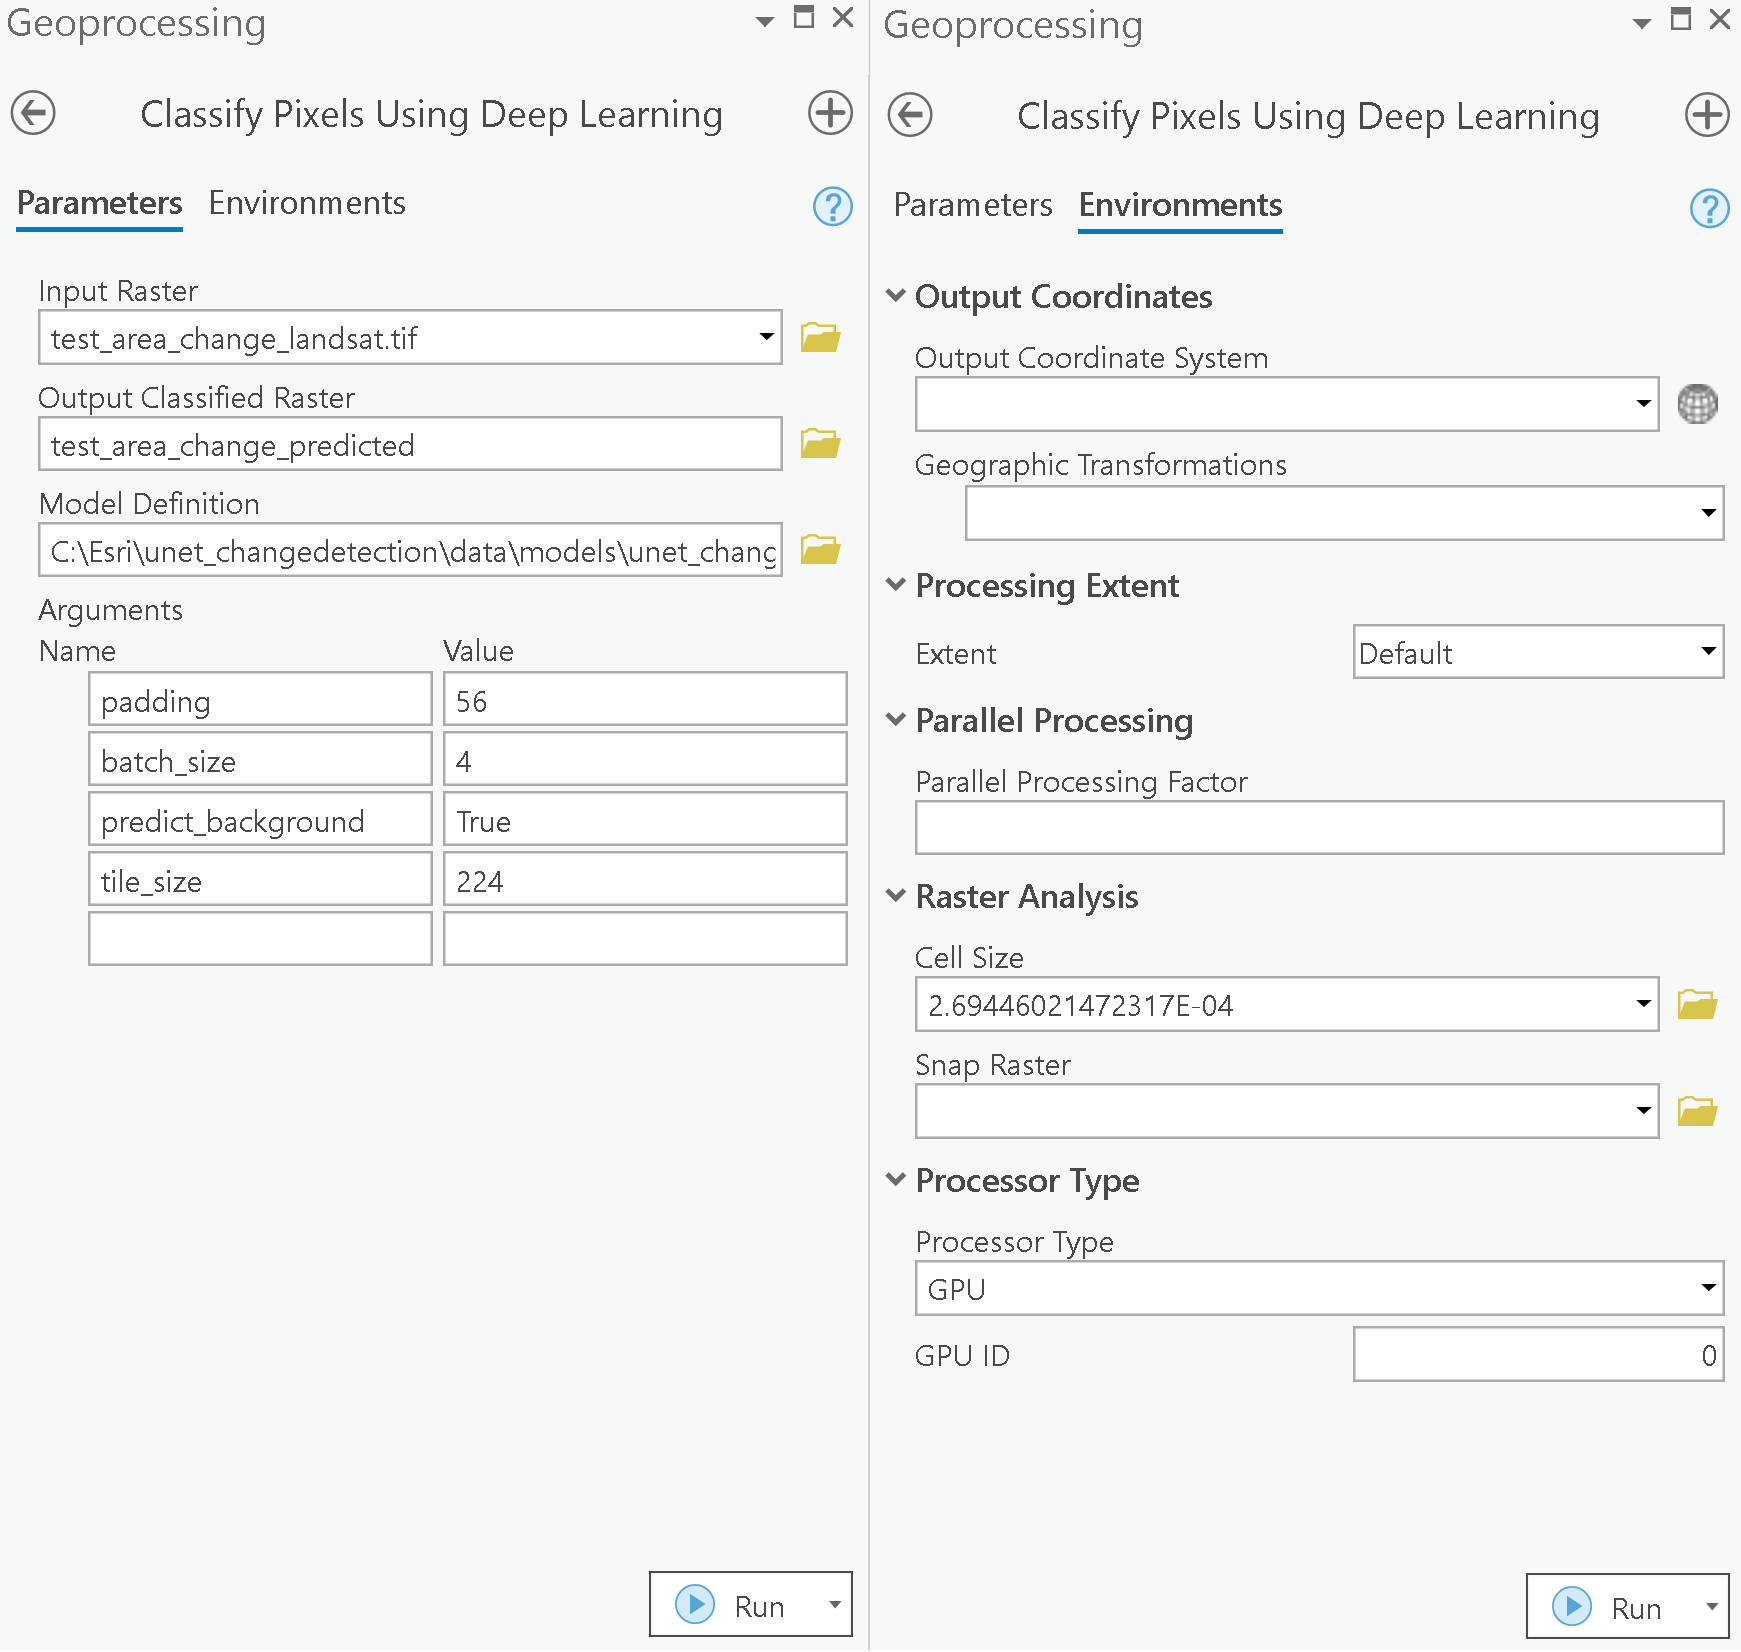

`out_classified_raster = arcpy.ia.ClassifyPixelsUsingDeepLearning("Imagery", r"C:\path\to\model.emd", "padding 56;batch_size 4;predict_background True;tile_size 224");` `out_classified_raster.save(r"C:\sample\sample.gdb\predicted_change")`

### Visualize change map

The below predicted image on test area, indicate the area changed with the final class it converted into.

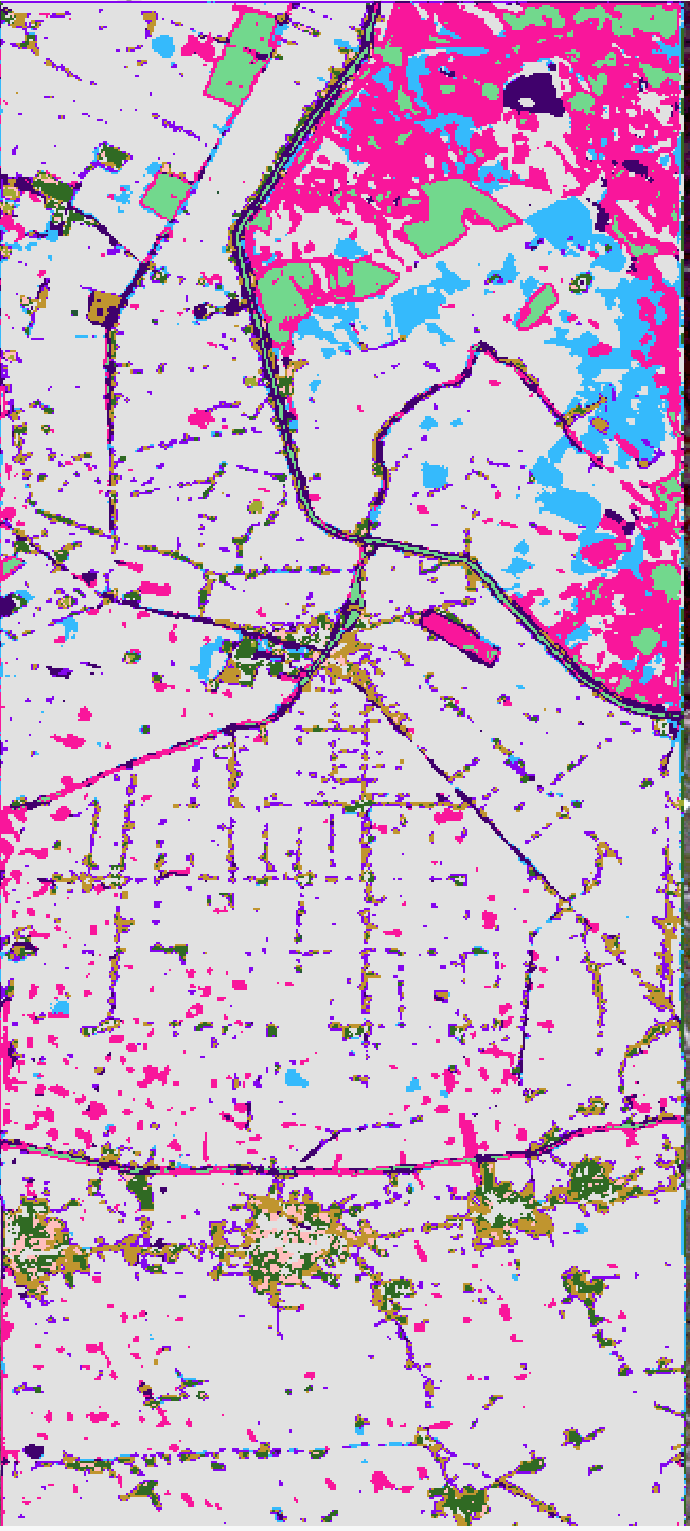

## Conclusion

In this notebook, we demonstrated how to use image segmentation models i.e. U-Net, DeepLab, PSPNet available in `arcgis.learn` in order to detect multi-class changes between imageries of two time-period.

## References

[1] Olaf Ronneberger, Philipp Fischer, Thomas Brox: U-Net: Convolutional Networks for Biomedical Image Segmentation, 2015;[arXiv:1505.04597](https://arxiv.org/abs/1505.04597) 